### The real-time feed and full historical archive of original resolution (Level II) NEXRAD data, from June 1991 to present, is now freely available on Amazon S3 for anyone to use. This is the first time the full NEXRAD Level II archive has been accessible to the public on demand. Now anyone can use the data on-demand in the cloud without worrying about storage costs and download time.

In [1]:
# based on http://eng.climate.com/2015/10/27/how-to-read-and-display-nexrad-on-aws-using-python/
# Requires python 2.7 for pyart
import matplotlib.pyplot as plt
import matplotlib
import numpy.ma as ma
import numpy as np
import pyart.graph
import tempfile
import pyart.io
import boto
%matplotlib inline

In [2]:
# read a volume scan file on S3. I happen to know this file exists.
s3conn = boto.connect_s3()
bucket = s3conn.get_bucket('noaa-nexrad-level2')
s3key = bucket.get_key('2015/05/15/KVWX/KVWX20150515_080737_V06.gz')
print s3key

<Key: noaa-nexrad-level2,2015/05/15/KVWX/KVWX20150515_080737_V06.gz>


In [3]:
# download to a local file, and read it
# open temp file
localfile = tempfile.NamedTemporaryFile()
# dump to temp file
s3key.get_contents_to_filename(localfile.name)
# parse temp file for pyart using built-in data cleaning
radar = pyart.io.read_nexrad_archive(localfile.name)

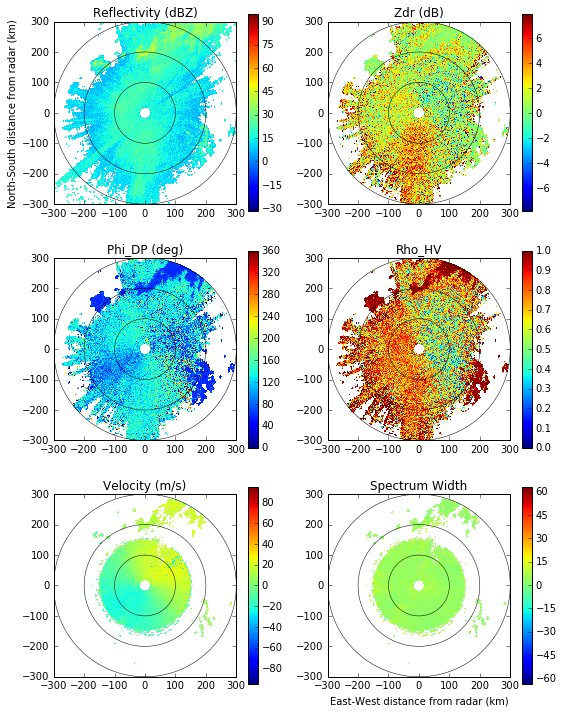

In [4]:
# display the lowest elevation scan data
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(9, 12))

plots = [
    # variable-name in pyart, display-name that we want, sweep-number of radar (0=lowest ref, 1=lowest velocity)
    # [variable name, title, sweep-number] 
    ['reflectivity', 'Reflectivity (dBZ)', 0],
    ['differential_reflectivity', 'Zdr (dB)', 0],
    ['differential_phase', 'Phi_DP (deg)', 0],
    ['cross_correlation_ratio', 'Rho_HV', 0],
    ['velocity', 'Velocity (m/s)', 1],
    ['spectrum_width', 'Spectrum Width', 1]
]

def plot_radar_images(plots):
    ncols = 2
    nrows = len(plots)/2
    for plotno, plot in enumerate(plots, start=1):
        ax = fig.add_subplot(nrows, ncols, plotno)
        display.plot(plot[0], plot[2], ax=ax, title=plot[1],
             colorbar_label='',
             axislabels=('East-West distance from radar (km)' if plotno == 6 else '', 
                         'North-South distance from radar (km)' if plotno == 1 else ''))
        display.set_limits((-300, 300), (-300, 300), ax=ax)
        display.set_aspect_ratio('equal', ax=ax)
        display.plot_range_rings(range(100, 350, 100), lw=0.5, col='black', ax=ax)
    plt.show()

plot_radar_images(plots)

In [9]:
refl_grid = radar.get_field(1, 'reflectivity')
print refl_grid[0]
rhohv_grid = radar.get_field(0, 'cross_correlation_ratio')
zdr_grid = radar.get_field(0, 'differential_reflectivity')

# apply rudimentary quality control
reflow = np.less(refl_grid, 20)
zdrhigh = np.greater(np.abs(zdr_grid), 2.3)
rhohvlow = np.less(rhohv_grid, 0.95)
notweather = np.logical_or(reflow, np.logical_or(zdrhigh, rhohvlow))
print notweather[0]

qcrefl_grid = ma.masked_where(notweather, refl_grid)
print qcrefl_grid[0]

[-16.0 -10.0 -11.5 ..., -- -- --]
[True True True ..., -- -- --]
[-- -- -- ..., -- -- --]


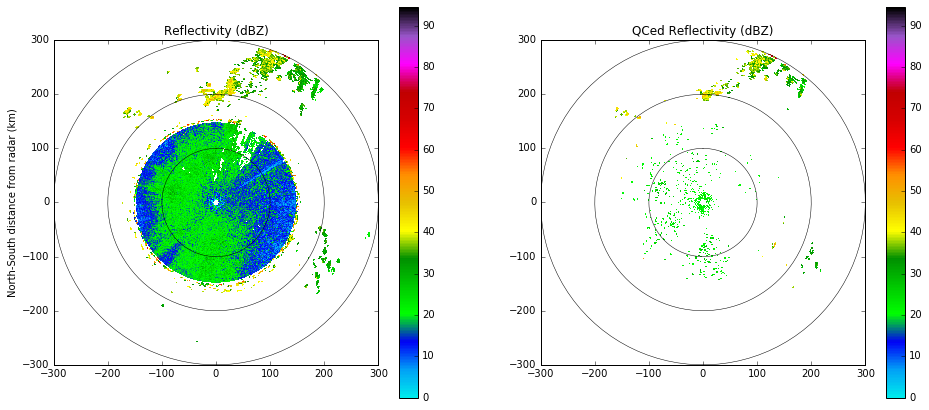

In [10]:
# let's create a new object containing only sweep=0 so we can add the QC'ed ref to it for plotting
qced = radar.extract_sweeps([1])
qced.add_field_like('reflectivity', 'reflectivityqc', qcrefl_grid)
display = pyart.graph.RadarDisplay(qced)
fig = plt.figure(figsize=(16, 7))

plots = [
    # variable-name in pyart, display-name that we want, sweep-number of radar (0=lowest ref, 1=lowest velocity)
    ['reflectivity', 'Reflectivity (dBZ)', 0],
    ['reflectivityqc', 'QCed Reflectivity (dBZ)', 0],
]

def plot_radar_images(plots):
    ncols = 2
    nrows = len(plots)/2
    for plotno, plot in enumerate(plots, start=1):
        ax = fig.add_subplot(nrows, ncols, plotno)
        display.plot(plot[0], plot[2], ax=ax, title=plot[1],
             colorbar_label='',
             axislabels=('East-West distance from radar (km)' if plotno == 6 else '', 
                         'North-South distance from radar (km)' if plotno == 1 else ''),
                    vmin = 0, cmap='pyart_NWSRef')
        display.set_limits((-300, 300), (-300, 300), ax=ax)
        display.set_aspect_ratio('equal', ax=ax)
        display.plot_range_rings(range(100, 350, 100), lw=0.5, col='black', ax=ax)
    plt.show()
    
    
plot_radar_images(plots)

[15.0 -3.5 -1.0 ..., -- -- --]
[True True True ..., -- -- --]
[-- -- -- ..., -- -- --]


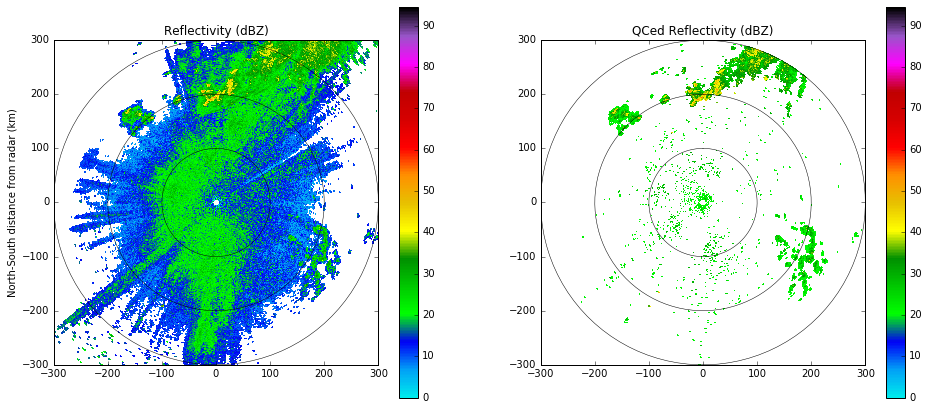

In [20]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def plotters(n):
    refl_grid = radar.get_field(n, 'reflectivity')
    print(refl_grid[0])
    rhohv_grid = radar.get_field(0, 'cross_correlation_ratio')
    zdr_grid = radar.get_field(0, 'differential_reflectivity')

    # apply rudimentary quality control
    reflow = np.less(refl_grid, 20)
    zdrhigh = np.greater(np.abs(zdr_grid), 2.3)
    rhohvlow = np.less(rhohv_grid, 0.95)
    notweather = np.logical_or(reflow, np.logical_or(zdrhigh, rhohvlow))
    print(notweather[0])

    qcrefl_grid = ma.masked_where(notweather, refl_grid)
    print(qcrefl_grid[0])
    # let's create a new object containing only sweep=0 so we can add the QC'ed ref to it for plotting
    qced = radar.extract_sweeps([n])
    qced.add_field_like('reflectivity', 'reflectivityqc', qcrefl_grid)
    display = pyart.graph.RadarDisplay(qced)
    fig = plt.figure(figsize=(16, 7))

    plots = [
        # variable-name in pyart, display-name that we want, sweep-number of radar (0=lowest ref, 1=lowest velocity)
        ['reflectivity', 'Reflectivity (dBZ)', 0],
        ['reflectivityqc', 'QCed Reflectivity (dBZ)', 0],
    ]

    def plot_radar_images(plots):
        ncols = 2
        nrows = len(plots)/2
        for plotno, plot in enumerate(plots, start=1):
            ax = fig.add_subplot(nrows, ncols, plotno)
            display.plot(plot[0], plot[2], ax=ax, title=plot[1],
                 colorbar_label='',
                 axislabels=('East-West distance from radar (km)' if plotno == 6 else '', 
                             'North-South distance from radar (km)' if plotno == 1 else ''),
                        vmin = 0, cmap='pyart_NWSRef')
            display.set_limits((-300, 300), (-300, 300), ax=ax)
            display.set_aspect_ratio('equal', ax=ax)
            display.plot_range_rings(range(100, 350, 100), lw=0.5, col='black', ax=ax)
        plt.show()
    plot_radar_images(plots)
    
interact(plotters, n=widgets.IntSlider(min=0,max=3,step=1,value=3));
